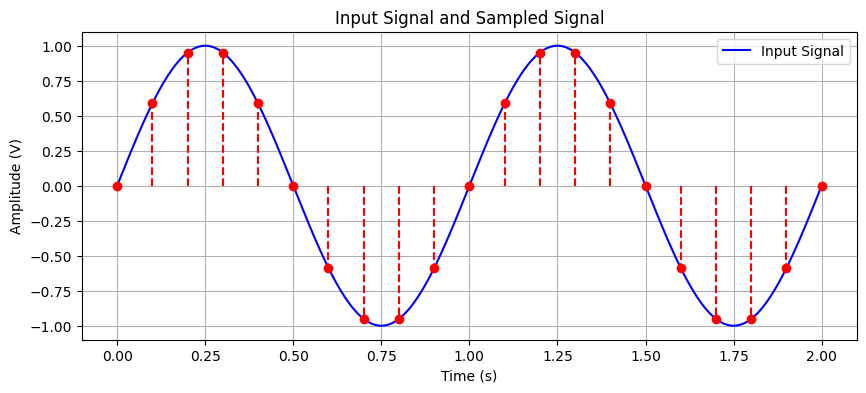

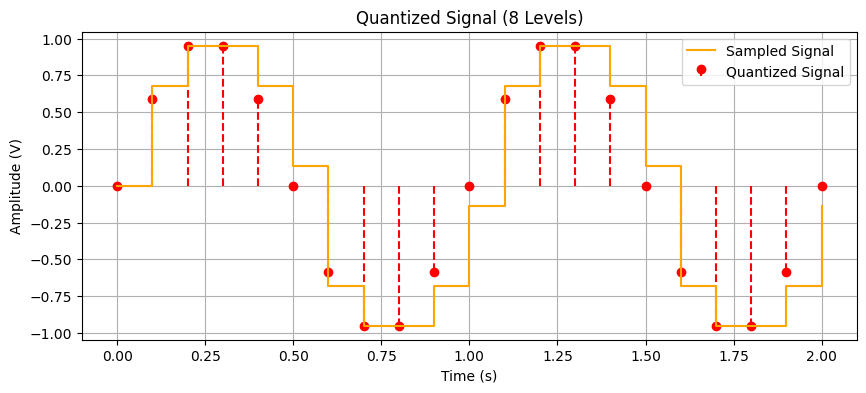

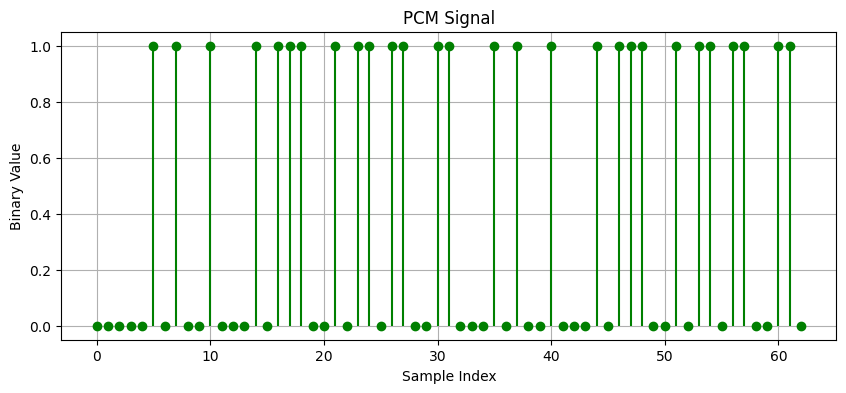

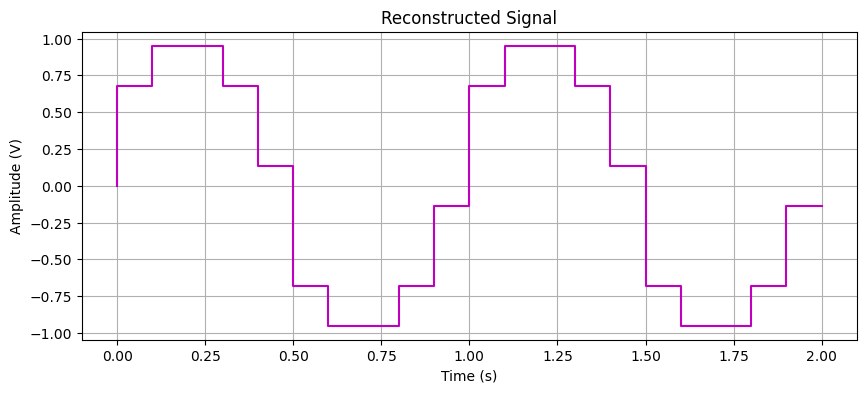

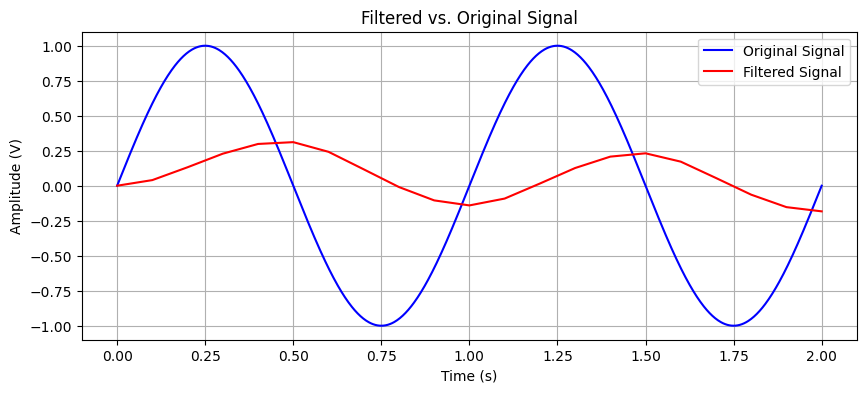

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import math as mt

# Input Signal 
W = 1  # Frequency in Hz
t = np.linspace(0, 2, 1000)  # 2 cycles of the signal
x = np.sin(2 * np.pi * W * t) 

# Sampling
fs = 10 * W  # Sampling frequency = 10 Hz (Nyquist rate = 2 Hz)
Ts = 1 / fs  # Sampling interval = 0.1 seconds
ts = np.arange(0, 2 + Ts, Ts)  # Time points for 2 cycles
x_s = np.sin(2 * np.pi * W * ts)  # Sampled signal

# Plot Input and Sampled Signals (Same as before)
plt.figure(figsize=(10, 4))
plt.plot(t, x, 'b', label='Input Signal')
plt.stem(ts, x_s, linefmt='r--', markerfmt='ro', basefmt=' ')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Input Signal and Sampled Signal")
plt.legend()
plt.grid()
plt.show()

# Quantization Functions 
def rounding(value):
    return (mt.floor(value) + mt.ceil(value)) / 2

def Uniform_quantizater(input_signal, level):
    step_size = 2 * max(input_signal) / (level - 1)
    return [rounding(i / step_size) * step_size for i in input_signal]

# 8-Level Quantization
levels = 8
bits = int(np.log2(levels))
Quantized_signal = Uniform_quantizater(x_s, levels)

# Plot Quantized Signal (8 Levels)
plt.figure(figsize=(10, 4))
plt.stem(ts, x_s, linefmt='r--', markerfmt='ro', basefmt=' ')
plt.step(ts, Quantized_signal, 'orange', where='post')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Quantized Signal (8 Levels)")
plt.legend(["Sampled Signal", "Quantized Signal"])
plt.grid()
plt.show()

# PCM Encoding \
def Tabular(Signal):
    return pd.DataFrame({'Levels': Signal}).drop_duplicates().reset_index(drop=True)

def Binary(level, bits):
    return [list(map(int, bin(i).lstrip('0b').zfill(bits))) for i in range(level)]

quantized_signal = Tabular(Quantized_signal)
if len(quantized_signal.Levels) < levels:
    print("Warning: Adjusting quantization levels...")
    levels = len(quantized_signal.Levels)

quantization_levels = quantized_signal.Levels.to_numpy()
X_bin = Binary(len(quantization_levels), bits)
Encoded = pd.DataFrame({'Quantization Level': quantization_levels.tolist(), 'Binary Representation': X_bin})

# Generate PCM Signal
pcm = []
quantization_map = dict(zip(Encoded["Quantization Level"], Encoded["Binary Representation"]))
for i in Quantized_signal:
    closest_level = min(quantization_levels, key=lambda x: abs(x - i))
    pcm.extend(quantization_map[closest_level])

# Plot PCM Signal
plt.figure(figsize=(10, 4))
plt.stem(range(len(pcm)), pcm, linefmt='g-', markerfmt='go', basefmt=' ')
plt.xlabel("Sample Index")
plt.ylabel("Binary Value")
plt.title("PCM Signal")
plt.grid()
plt.show()

# Signal Reconstruction (Same as before)
reconstructed_signal = []
for i in range(0, len(pcm), bits):
    binary_sequence = pcm[i:i+bits]
    match = Encoded.loc[Encoded['Binary Representation'].apply(lambda x: x == binary_sequence)]
    reconstructed_signal.append(match['Quantization Level'].values[0] if not match.empty else 0)

t_reconstructed = np.linspace(ts[0], ts[-1], len(reconstructed_signal))

# Plot Reconstructed Signal
plt.figure(figsize=(10, 4))
plt.step(t_reconstructed, reconstructed_signal, 'm')
plt.title("Reconstructed Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.grid()
plt.show()

# Filtering (Critical Fix: Normalized Cutoff Frequency)
Fc = W  # Cutoff frequency = 1 Hz (same as input signal)
nyquist = fs / 2  # Nyquist frequency = 5 Hz
normalized_cutoff = Fc / nyquist  # 0.2 (must be < 1)

# Design Butterworth filter
b, a = signal.butter(1, normalized_cutoff, btype='low', fs=fs)
filtered_signal = signal.lfilter(b, a, reconstructed_signal)

# Plot Filtered vs. Original
plt.figure(figsize=(10, 4))
plt.plot(t, x, 'b', label='Original Signal')
plt.plot(t_reconstructed, filtered_signal, 'r', label='Filtered Signal')
plt.title("Filtered vs. Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.grid()
plt.show()